# Importing libraries 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle

# 1. Load and Explore the Dataset

In [14]:
sales = pd.read_csv('sales copy.csv')
sales.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [15]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


# 2. Data cleaning

In [16]:
sales.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [17]:
sales=sales.drop(["Unnamed: 0"],axis=1)
sales.head()

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882


In [18]:
#Change dtype of 'date' column from object to integer

sales['date'] = pd.to_datetime(sales['date'],format='%Y-%m-%d') # Convert the 'Date' column values from string to datetime
sales['date'] = sales['date'].apply(lambda x: x.toordinal()) # Convert the datetime values to numeric using toordinal()

In [19]:
#Change dtype of 'state_holiday' column from object to integer
mapping = {'0': 0, 'a': 1, 'b': 1, 'c': 1}

# Apply the mapping to the 'state_holiday' column
sales['state_holiday'] = sales['state_holiday'].map(mapping)

In [20]:
#Check if there is any missing value
sales.isna().sum()

store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [21]:
#check if there is a case where the store is closed but sales are not 0
sales[sales["open"]==0]["sales"].unique()

array([0])

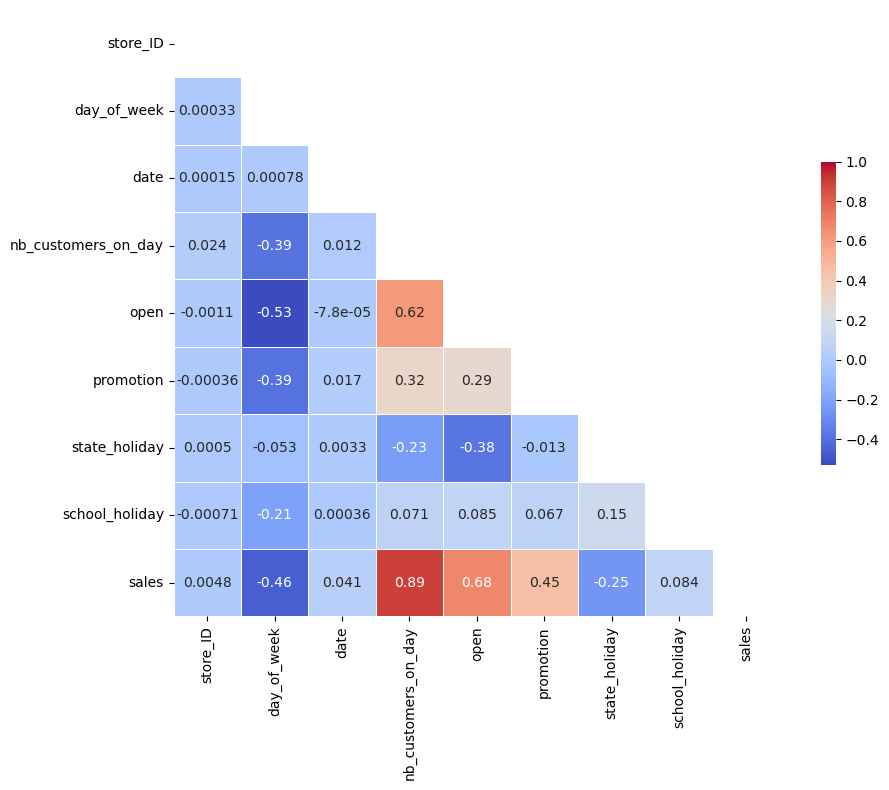

In [22]:
#Create a heatmap  to visualize which columns have high collinearity.

corr = sales.select_dtypes(include=['int64', 'float64']).corr()
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = 'coolwarm'

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, cmap=cmap, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#any columns have high collinearity.


In [23]:
#check if there is a case where the store is open but there is state holiday.
sales[(sales['state_holiday']==1) & (sales['open']==1)]

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
216,676,3,735234,946,1,0,1,1,5755
1529,582,1,735393,493,1,0,1,0,2146
1984,178,4,735018,962,1,1,1,0,10796
6382,780,4,735753,1060,1,1,1,0,8646
6465,178,4,735753,964,1,1,1,0,12155
...,...,...,...,...,...,...,...,...,...
637520,318,4,735403,755,1,1,1,0,8610
637629,95,4,735753,884,1,1,1,0,8317
638583,777,5,735509,190,1,1,1,0,1880
639009,1074,4,735018,679,1,1,1,0,6758


In [24]:
sales.dtypes

store_ID               int64
day_of_week            int64
date                   int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
dtype: object

# 3. Splitting the data

In [25]:
X = sales.drop(columns=['sales'])
y = sales['sales']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# 4. Prediction models

## 4.1. Linear regression

In [28]:
# Create linear regression
linear_regression = LinearRegression()

# Train the linear regression
model = linear_regression.fit(X_train, y_train)

In [29]:
y_train_pred = model.predict(X_train)
print('R2 score for train set is:',r2_score(y_train, y_train_pred))

R2 score for train set is: 0.8536491835395812


In [30]:
y_test_pred = model.predict(X_test)
print('R2 score for test set is:',r2_score(y_test, y_test_pred))

R2 score for test set is: 0.8555918746403675


In [31]:
# Convert the predictions to a DataFrame for easier manipulation
y_test_pred_dataframe = pd.DataFrame(y_test_pred, columns=['sales_prediction'], index=X_test.index)

y_test_pred_dataframe.loc[X_test['open'] == 0, 'sales_prediction'] = 0

result_with_post_processing = pd.concat([X_test, y_test_pred_dataframe], axis=1)

display(result_with_post_processing)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales_prediction
235371,924,2,735590,807,1,0,0,1,6876.715167
613498,1081,2,735359,1281,1,1,0,0,10843.154157
239642,215,4,735403,0,0,1,1,1,0.000000
457903,783,6,735083,582,1,0,0,0,4954.737441
458334,165,2,735184,408,1,0,0,0,4336.429340
...,...,...,...,...,...,...,...,...,...
173075,206,6,734957,809,1,0,0,0,6362.004143
366955,224,6,735405,522,1,0,0,0,4808.149532
27478,247,4,735767,695,1,1,0,0,7433.148822
328331,174,4,735613,496,1,1,0,0,6172.987517


## 4.2. Decision Tree Regression

In [32]:
regr = DecisionTreeRegressor()

# Train regression tree model
sales_treer = regr.fit(X_train, y_train)

In [33]:
y_train_pred = sales_treer.predict(X_train)
print('R2 score for train set is:',r2_score(y_train, y_train_pred))
#this result (R2=1)indicates overfitting, where the model fits the training data too closely 
#and may not generalize well to unseen data.

R2 score for train set is: 1.0


In [34]:
y_test_pred = sales_treer.predict(X_test)
print('R2 score for test set is:',r2_score(y_test, y_test_pred))

R2 score for test set is: 0.9092083088880739


## 5. Parameters optimitation

In [35]:
training_R2 = []
test_R2 = []

# try max_depth from 1 to 20
max_depth = range(1,20)

for depth in max_depth:
  tree = DecisionTreeRegressor(max_depth= depth)
  tree.fit(X_train, y_train)

  y_train_pred = tree.predict(X_train)
  y_test_pred = tree.predict(X_test)
 
  training_R2.append(r2_score(y_train, y_train_pred))
  test_R2.append(r2_score(y_test, y_test_pred))

plt.plot(max_depth, training_R2, label="training R2")
plt.plot(max_depth, test_R2, label="test R2")
plt.ylabel("R2")
plt.xlabel("max_depth")
plt.legend()

plt.show()

KeyboardInterrupt: 

In [ ]:
#10 branches is the optimal

In [36]:
#Decision tree with max_depth = 10

# Create decision tree classifer object
decision_tree = DecisionTreeRegressor(max_depth=10)

# Train regression tree model
sales_treer = regr.fit(X_train, y_train)

# Score the model
y_train_pred = sales_treer.predict(X_train)
print('R2 score for train set is:',r2_score(y_train, y_train_pred))

y_test_pred = sales_treer.predict(X_test)
print('R2 score for test set is:',r2_score(y_test, y_test_pred))

R2 score for train set is: 1.0
R2 score for test set is: 0.9084733673315354


## 6. Improving model by ensemble methods

### 6.1 Bagging

In [37]:
bagging_reg = BaggingRegressor(
    DecisionTreeRegressor(max_depth=10),
    n_estimators=50,
    max_samples=100,
    random_state=1) # fixing rand because I'm insecure and afraid you will judge me if I get a bad random selection that does not prove my point

In [38]:
bagging_reg.fit(X_train, y_train)
y_test_pred = bagging_reg.predict(X_test)
print('R2 score for test set is:',r2_score(y_test, y_test_pred))

R2 score for test set is: 0.852986677630009


In [39]:
#Check test results
#When store is closed sales_prediction should be 0.
y_test_pred = pd.DataFrame(y_test_pred, columns=['sales_prediction'], index=X_test.index)

result_test = pd.concat([pd.DataFrame(X_test), y_test_pred], axis=1)

display(result_test)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales_prediction
235371,924,2,735590,807,1,0,0,1,6885.300000
613498,1081,2,735359,1281,1,1,0,0,10999.470000
239642,215,4,735403,0,0,1,1,1,114.760000
457903,783,6,735083,582,1,0,0,0,5524.896500
458334,165,2,735184,408,1,0,0,0,4173.113333
...,...,...,...,...,...,...,...,...,...
173075,206,6,734957,809,1,0,0,0,7206.260000
366955,224,6,735405,522,1,0,0,0,5275.245000
27478,247,4,735767,695,1,1,0,0,7301.655000
328331,174,4,735613,496,1,1,0,0,5414.460000


### 6.2 Random Forests

In [40]:
forest = RandomForestRegressor(n_estimators=50, 
                               max_depth=10, 
                               random_state=1) 
forest.fit(X_train, y_train)
y_test_pred = forest.predict(X_test)
print('R2 score for test set is:',r2_score(y_test, y_test_pred))

R2 score for test set is: 0.8935649399958914


In [41]:
#Check test results
#When store is closed sales_prediction should be 0.
y_test_pred = pd.DataFrame(y_test_pred, columns=['sales_prediction'], index=X_test.index)

result_test = pd.concat([pd.DataFrame(X_test), y_test_pred], axis=1)

display(result_test)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales_prediction
235371,924,2,735590,807,1,0,0,1,7694.424593
613498,1081,2,735359,1281,1,1,0,0,11249.301176
239642,215,4,735403,0,0,1,1,1,0.000000
457903,783,6,735083,582,1,0,0,0,5496.274139
458334,165,2,735184,408,1,0,0,0,4062.636601
...,...,...,...,...,...,...,...,...,...
173075,206,6,734957,809,1,0,0,0,7057.812563
366955,224,6,735405,522,1,0,0,0,5193.721486
27478,247,4,735767,695,1,1,0,0,7357.918486
328331,174,4,735613,496,1,1,0,0,5819.262860


### 6.3 Adaboost

In [42]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), 
                            n_estimators=50, 
                            random_state=1 
                            )
ada_reg.fit(X_train, y_train)
ada_reg.score(X_test,y_test)

0.8971448743735781

In [43]:
#Check test results
#When store is closed sales_prediction should be 0.
y_test_pred = pd.DataFrame(y_test_pred, columns=['sales_prediction'], index=X_test.index)

result_test = pd.concat([pd.DataFrame(X_test), y_test_pred], axis=1)

display(result_test)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales_prediction
235371,924,2,735590,807,1,0,0,1,7694.424593
613498,1081,2,735359,1281,1,1,0,0,11249.301176
239642,215,4,735403,0,0,1,1,1,0.000000
457903,783,6,735083,582,1,0,0,0,5496.274139
458334,165,2,735184,408,1,0,0,0,4062.636601
...,...,...,...,...,...,...,...,...,...
173075,206,6,734957,809,1,0,0,0,7057.812563
366955,224,6,735405,522,1,0,0,0,5193.721486
27478,247,4,735767,695,1,1,0,0,7357.918486
328331,174,4,735613,496,1,1,0,0,5819.262860


In [45]:
#check the situation when store is closed.
result_test[result_test['open']==0]

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales_prediction
239642,215,4,735403,0,0,1,1,1,0.0
262940,11,7,735805,0,0,0,0,0,0.0
311013,626,7,735707,0,0,0,0,0,0.0
471541,171,7,735588,0,0,0,0,0,0.0
379565,634,7,735420,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
426019,365,4,734997,0,0,0,1,0,0.0
602066,629,7,734972,0,0,0,0,0,0.0
176098,256,7,735686,0,0,0,0,0,0.0
255662,760,7,735777,0,0,0,0,0,0.0


In [ ]:
"""# Convert the predictions to a DataFrame for easier manipulation
y_train_pred = pd.DataFrame(y_train_pred, columns=['sales_prediction'], index=X_test.index)

# Post-processing: Set predicted sales to 0 for days when the store is closed (open == 0)
y_train_pred.loc[X_test['open'] == 0, 'sales_prediction'] = 0

# Optionally, merge the predictions back with X_test for a complete view
result_with_post_processing_ada = pd.concat([X_test, y_train_pred], axis=1)

# Display the result with post-processing
display(result_with_post_processing_ada)"""

"# Convert the predictions to a DataFrame for easier manipulation\ny_train_pred = pd.DataFrame(y_train_pred, columns=['sales_prediction'], index=X_test.index)\n\n# Post-processing: Set predicted sales to 0 for days when the store is closed (open == 0)\ny_train_pred.loc[X_test['open'] == 0, 'sales_prediction'] = 0\n\n# Optionally, merge the predictions back with X_test for a complete view\nresult_with_post_processing_ada = pd.concat([X_test, y_train_pred], axis=1)\n\n# Display the result with post-processing\ndisplay(result_with_post_processing_ada)"

In [46]:
model_pipeline = [linear_regression, decision_tree,bagging_reg, forest, ada_reg]

train_score = []
test_score = []
cross_scores = []
mse = []
rmse = []
r2_values = []

for model in model_pipeline:
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
    cross_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5)))
    mse_calculated = mean_squared_error(y_test,model.predict(X_test))
    mse.append(mse_calculated)
    rmse.append(math.sqrt(mse_calculated))
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_values.append(r2)

In [47]:
summary = {'Train Score':train_score,
           'Test Score':test_score,
           'Cross Score':cross_scores,
            'mse':mse,
          'rmse':rmse,
          'R²':r2_values}
summary = pd.DataFrame(summary).T
summary.columns = 'LinearRegression','DecisionTree','BaggingRegressor','RandomForestRegressor','AdaBoostRegressor'

In [48]:
summary

,LinearRegression,DecisionTree,BaggingRegressor,RandomForestRegressor,AdaBoostRegressor
Train Score,8.536492e-01,8.895095e-01,8.515187e-01,8.947147e-01,9.011948e-01
Test Score,8.555919e-01,8.885600e-01,8.529867e-01,8.935649e-01,8.971449e-01
Cross Score,8.536359e-01,8.860587e-01,8.557944e-01,8.927445e-01,8.989285e-01
mse,2.154493e+06,1.662626e+06,2.193361e+06,1.587955e+06,1.534544e+06
rmse,1.467819e+03,1.289429e+03,1.481000e+03,1.260141e+03,1.238767e+03
R²,8.555919e-01,8.885600e-01,8.529867e-01,8.935649e-01,8.971449e-01


## 7. Predicting the sales

In [57]:
sales_validation = pd.read_csv('validation_for students.csv')
sales_validation.head(10)

,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,272371,415,7,01/03/2015,0,0,0,0,0
1,558468,27,7,29/12/2013,0,0,0,0,0
2,76950,404,3,19/03/2014,657,1,1,0,0
3,77556,683,2,29/01/2013,862,1,0,0,0
4,456344,920,3,19/03/2014,591,1,1,0,0
5,436466,758,4,26/06/2014,569,1,0,0,0
6,646251,563,1,16/02/2015,321,1,1,0,0
7,650464,930,6,22/11/2014,1367,1,0,0,0
8,162710,756,4,04/06/2015,0,0,1,a,0
9,100327,49,2,13/01/2015,546,1,1,0,0


In [58]:
sales_validation.dtypes

index                   int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
dtype: object

In [59]:
#Change dtype of 'date' column from object to integer

sales_validation['date'] = pd.to_datetime(sales_validation['date'], format="%d/%m/%Y") # Convert the 'Date' column values from string to datetime
sales_validation['date'] = sales_validation['date'].apply(lambda x: x.toordinal()) # Convert the datetime values to numeric using toordinal()

In [60]:
#Change dtype of 'state_holiday' column from object to integer

mapping = {'0': 0, 'a': 1, 'b': 1, 'c': 1}

# Apply the mapping to the 'state_holiday' column
sales_validation['state_holiday'] = sales_validation['state_holiday'].map(mapping)

In [61]:
#Check if there is any missing value
sales_validation.isna().sum()

index                  0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
dtype: int64

In [62]:
predicted_sales_adareg = pd.DataFrame(ada_reg.predict(sales_validation.drop(columns='index')), columns=['Sales'])
predicted_sales_adareg.head(10)

,Sales
0,0.000000
1,0.000000
2,7292.327094
3,7567.950549
4,6814.153943
5,5520.036747
6,4250.352941
7,9355.737705
8,0.000000
9,6946.548077


## 8. Exporting the prediction

In [63]:
pd.concat([sales_validation['index'], predicted_sales_adareg['Sales']], axis=1).to_excel('predicted_sales.xlsx', index=False)

## 9. Save model in pickle

In [56]:
#Save the model in pickle file
pickle.dump(ada_reg, open('adareg_model.pkl', 'wb'))

X_test.to_pickle('xtest.p')
y_test.to_pickle('ytest.p')

In [ ]:
#Unpickle the model file
X_test = pd.read_pickle('xtest.p')
y_test = pd.read_pickle('ytest.p')
display(X_test.head())
display(y_test.head())

xgb_model = pickle.load(open('adareg_model.pkl','rb'))

xgb_model.score(X_test,y_test)
